# Dissertation: Community Detection Illustration

In [1]:
import networkx as nx
import networkx.algorithms.community as nx_comm
import random
import itertools
from networkx.generators.community import LFR_benchmark_graph
from sklearn.metrics.cluster import normalized_mutual_info_score

# For plotting
import matplotlib.pyplot as plt

## Generate Graph without Label
We can use call the networkx library to construct random graphs with given count of nodes and count of edges.

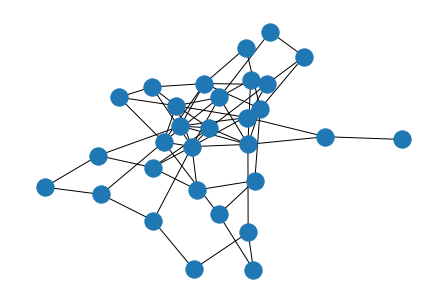

In [2]:
G = nx.gnm_random_graph(30,60)
nx.draw(G)

## Louvain Algorithm

Partition via Louvain's method is:

{0, 8, 6}
{16, 29, 4, 25, 12, 13}
{2, 7, 11, 14, 15, 18, 21, 27, 28}
{17, 19, 20, 9}
{10, 3, 22}
{1, 5, 23, 24, 26}


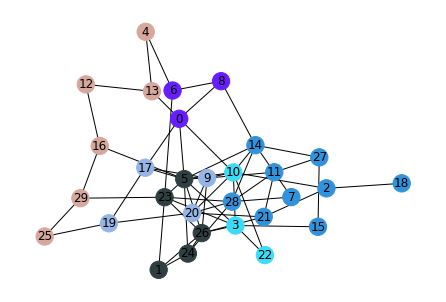

In [3]:
p1 = nx_comm.louvain_communities(G)
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(len(p1))]

color_map = []
for node in G:
    for group_index, group in enumerate(p1):
        if node in group: color_map.append(color[group_index])
print("Partition via Louvain's method is:\n\n" + "\n".join([str(ele) for ele in p1]))
nx.draw(G, node_color=color_map, with_labels=True)

In [17]:
# https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.centrality.girvan_newman.html
def color_by_community(G, communities):
    color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(len(communities))]

    color_map = []
    for node in G:
        for group_index, group in enumerate(communities):
            if node in group: color_map.append(color[group_index])

    print("Partition via the method is:\n\n" + "\n".join([str(ele) for ele in communities]))
    nx.draw(G, node_color=color_map, with_labels=True)
    return G

## Girvan-Newman Algorithm

In this section, we implement Girvan-Newman algorithm to the graph for illustration. Due to the nature of algorithm, we can conduct the partition iteratively and observe how it works. For simplicity purpose, the partition of the 6th iteration is chosen for this section.

Partition via the method is:

{0, 8, 6}
{1, 3, 5, 9, 10, 11, 20, 21, 22, 23, 24, 26}
{2, 18}
{4, 12, 13, 16, 25, 29}
{28, 14, 7}
{27, 15}
{17, 19}


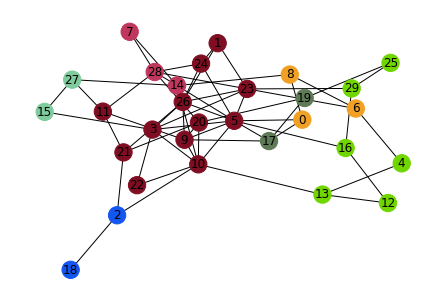

In [5]:
comp = nx_comm.girvan_newman(G)
[next(comp) for i in range(5)]
color_by_community(G, next(comp))

## Creating Artificial Network For Algorithm Testing

In the previous section, we created a network without labels. The labeling process does not affect the performance of algorithms, but can evaluate how accurate a result of a algorithm is. 

### LFR benchmark graph

Partition via the method is:

frozenset({1, 3, 7, 8, 13, 14, 20, 23, 24, 27, 28, 29, 31, 40, 46, 51, 52, 54, 55, 58, 61, 62, 63, 64, 65, 69, 72, 75, 76, 77, 78, 82, 83, 85, 88, 101, 106, 108, 112, 113, 117, 121, 147, 200, 203, 207, 209, 210, 211, 212, 213, 214, 215, 216, 219, 220, 224, 225, 226, 227, 228, 229, 231, 233, 234, 239, 240, 242, 243, 246, 247, 249})
frozenset({196, 16, 18, 19, 21, 22, 153, 157, 161, 34, 33, 36, 165, 38, 39, 44, 45, 172, 178, 122, 189})
frozenset({0, 2, 4, 5, 6, 9, 10, 11, 12, 15, 17, 25, 26, 30, 32, 35, 37, 41, 42, 43, 47, 48, 49, 50, 53, 56, 57, 59, 60, 66, 67, 68, 70, 71, 73, 74, 79, 80, 81, 84, 86, 87, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 102, 103, 104, 105, 107, 109, 110, 111, 114, 115, 116, 118, 119, 120, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 148, 149, 150, 151, 152, 154, 155, 156, 158, 159, 160, 162, 163, 164, 166, 167, 168, 169, 170, 171, 173, 174, 175, 176, 

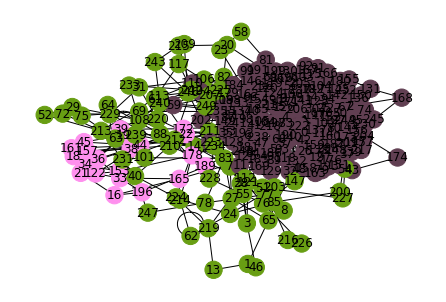

In [6]:
# https://networkx.org/documentation/stable/reference/generated/networkx.generators.community.LFR_benchmark_graph.html
n = 250
tau1 = 3
tau2 = 1.5
mu = 0.1
G = LFR_benchmark_graph(
    n, tau1, tau2, mu, average_degree=5, min_community=20, seed=10
)
color_by_community(G, communities = {frozenset(G.nodes[v]["community"]) for v in G})

## Evaluation
To evaluate the result of algorithm, we can either compute their performance, which is $$\frac{\text{edge of intra-community} + \text{non-edge of inter-community}}{\text{total potential edges}}.$$ Normally, higher the performance will result in better partition since either more edges inside each community or less edges between communities.

However, the performance evaluation does not take the true labels into consideration, it solely consider the structure and the 'tightness' of the partition. To compute the accuracy of a partition, we introduce the normalized mutual information. The idea is learned from the information theory. The NMI takes two parameters: a ground-truth partition and a computed partion. The math part behind NMI can be found [here](https://luisdrita.com/normalized-mutual-information-a10785ba4898). In short, the NMI score is between 0 and 1(inclusive), 1 indicates the two partition are perfectly correlated while 0 indicates two partitions are completely not correlated.

### Performance of Louvain Algorithm
We can see the the performance of Louvain algorithm is 0.87 which is pretty good.

Partition via the method is:

{192, 0, 4, 5, 70, 68, 137, 140, 208, 80, 149, 87, 26, 223, 102, 230, 169, 170, 107, 173, 238, 110, 181, 118, 53, 248, 57, 190, 127}
{32, 129, 35, 133, 11, 109, 60, 146, 184, 89, 188, 125, 158, 191}
{196, 16, 18, 19, 21, 22, 153, 157, 161, 34, 33, 36, 165, 38, 39, 172, 44, 45, 178, 122, 189}
{130, 135, 139, 12, 143, 15, 17, 148, 151, 152, 25, 156, 30, 159, 160, 163, 164, 37, 166, 42, 47, 48, 49, 177, 50, 180, 182, 56, 186, 187, 195, 197, 198, 200, 73, 201, 204, 205, 206, 79, 84, 217, 90, 92, 93, 95, 97, 104, 105, 232, 236, 237, 114, 126}
{193, 132, 199, 71, 9, 138, 144, 23, 218, 91, 94, 96, 167, 171, 43, 174, 175, 111, 176, 120, 185, 58, 123}
{194, 99, 162, 134, 103, 10, 202, 235, 145, 115, 179, 116, 86, 59}
{128, 2, 131, 66, 67, 136, 74, 141, 142, 150, 155, 222, 100, 168, 241, 244, 245, 119, 124}
{81, 98, 6, 183, 41, 154, 221}
{1, 3, 7, 8, 13, 14, 20, 24, 27, 28, 29, 31, 40, 46, 51, 52, 54, 55, 61, 62, 63, 64, 65, 69, 72, 75, 76, 77, 78, 82, 83, 85, 88, 1

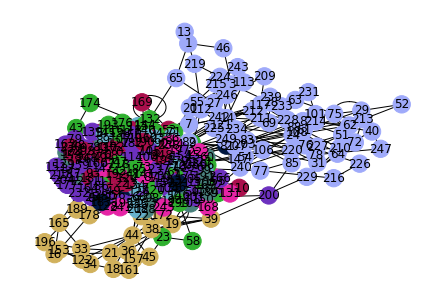

In [7]:
p1 = nx_comm.louvain_communities(G)
nx_comm.partition_quality(G, p1)[1]
color_by_community(G, p1)

### Performance of Grivan Newman Algorithm
Since GN algorithm is a divisive hierarchical algorithm, we can iterate a bit more generations and see how it goes. We can tell that as the iteration increases, the performance can eventually approach to 1 since all the node will ultimately turn into a community.

Text(0, 0.5, 'Performance')

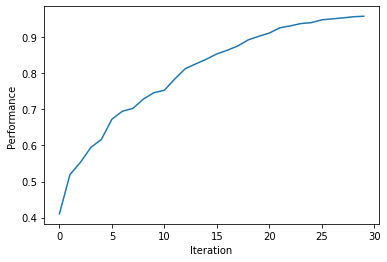

In [8]:
iteration = [i for i in range(30)]
comp = nx_comm.girvan_newman(G)
perforamnce = [nx_comm.partition_quality(G, next(comp))[1] for i in range(30)]

plt.plot(iteration, perforamnce)
plt.xlabel('Iteration')
plt.ylabel('Performance')

### Normalized Mutual Information Evalutation
As meanioned, we can expect the score of NMI to be higher if the partition of an algorithm is more *similar* to the ground truth partition, and lower the value otherwise. Since there is not in-built function to do the job, let's make one here.

In [9]:
def nmi_calculator(true_label, pred_lebel):
    """
    The function takes 2 parameters, one is the ground truth and the other is the result
    of an algorithm. The function will then construct lists of labels corresponding to 
    ther order of node. After construction of label list, we call the mni score function
    from scikit package for calculation.
    """
    pred_label_list = [0]*len(G)
    true_label_list = [0]*len(G)
    
    for index, comm in enumerate(true_label):
        for node in comm:
            true_label_list[node] = index
    for index, comm in enumerate(pred_lebel):
        for node in comm:
            pred_label_list[node] = index
    nmi_score = normalized_mutual_info_score(true_label_list, pred_label_list)

    return nmi_score

In [10]:
ground_truth = {frozenset(G.nodes[v]["community"]) for v in G}

### NMI Score of Louvain Algorithm

The result of the calcuation indicates that the partition of louvain algorithm may not reveal the true labels perfectly.

In [11]:
nmi_calculator(ground_truth, p1)

0.5713023255361936

### NMI Score of Girvan Newman Algorithm

Similar to retrieving the performance of Girvan Newman algorithm, we can run the evaluation iteratively and find the best result.

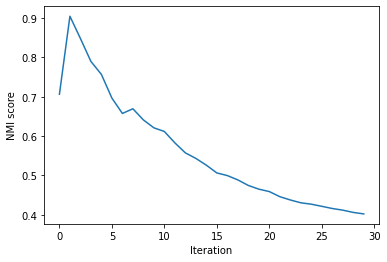

In [12]:
iteration = [i for i in range(30)]
comp = nx_comm.girvan_newman(G)
nmi_score_list = [nmi_calculator(ground_truth, next(comp)) for i in range(30)]

plt.plot(iteration, nmi_score_list)
plt.xlabel('Iteration')
plt.ylabel('NMI score')

best_score_index = nmi_score_list.index(max(nmi_score_list))
best_score = max(nmi_score_list)

The result indicates that at iteration 1, the NMI score peaks to the max, which is 0.90. The NMI score suggest that the partition of GN algorithm at the first iteration is highly correlated to the ground truth. Unsuprisingly, by implementing visual comparison, we can observe the high similarity between the partition and the ground truth.

The best NMI score is achieved at iteration 1 with NMI score of 0.9048195686488626

Partition via the method is:

{0, 2, 4, 5, 6, 9, 10, 11, 12, 15, 17, 20, 23, 25, 26, 30, 32, 35, 37, 41, 42, 43, 47, 48, 49, 50, 53, 56, 57, 58, 59, 60, 66, 67, 68, 70, 71, 73, 74, 79, 80, 81, 82, 84, 86, 87, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 102, 103, 104, 105, 106, 107, 109, 110, 111, 114, 115, 116, 118, 119, 120, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 148, 149, 150, 151, 152, 154, 155, 156, 158, 159, 160, 162, 163, 164, 166, 167, 168, 169, 170, 171, 173, 174, 175, 176, 177, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 190, 191, 192, 193, 194, 195, 197, 198, 199, 201, 202, 204, 205, 206, 208, 217, 218, 221, 222, 223, 230, 232, 235, 236, 237, 238, 241, 244, 245, 248}
{1, 3, 7, 8, 13, 14, 147, 24, 27, 28, 29, 31, 40, 46, 51, 52, 54, 55, 61, 62, 63, 64, 65, 69, 200, 72, 203, 76, 77, 78, 75, 207, 209, 210,

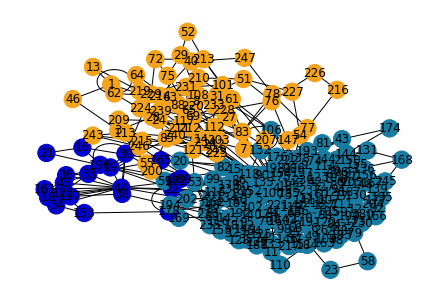

In [13]:
print("The best NMI score is achieved at iteration {} with NMI score of {}\n".format(best_score_index, best_score))

comp = nx_comm.girvan_newman(G)
if best_score_index != 0:
    [next(comp) for i in range(best_score_index)]
color_by_community(G, next(comp))

## Future Work

1. Read more papers about evaluation.
2. Importing real-world dataset.
3. Introduce few more community detection algorithms to my disseration.

## Images for Dissertation

Figure 1: 

Partition via the method is:

{0, 1, 2, 4, 7, 8}
{9, 3, 5, 6}


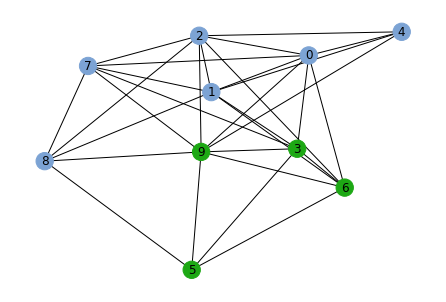

In [21]:
G = nx.gnm_random_graph(10,30)
p1 = nx_comm.louvain_communities(G)
color_by_community(G, p1)
plt.savefig("fig_1.png", format="PNG")
